<a href="https://colab.research.google.com/github/Sarthakh/Automatic-Image-Colorization-Using-Auto-encoders-without-Image-Compression/blob/main/CNN_Model_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Autoencoder model for auto-colorization</h1>

<h2>Library imports</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, Dropout
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras import backend as K
import pandas as pd

<h2>Defining the RGB to Gray Transition function

In [2]:
#Using cv2.cvtcolor(image, cv2.color_scheme)
#Input coloured image and returned the gray image
def rgb_gray(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

<h2>Loading Data</h2>

In [3]:
#Loading the training and testing dataset from Keras datasets
#Here, x_train is our training set and x_test is our validation set
#We do not require the y_train/y_test dataset as we are not performing image classification with target labels
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#Dimensions of each of the sets
print(x_train.shape)
print(x_test.shape)
#Getting the height, width and number of channels from the image
img_dim = x_train.shape[1]
channels = 3

170508288/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


<h2>Displaying sample images from the dataset with their respective class</h2>

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


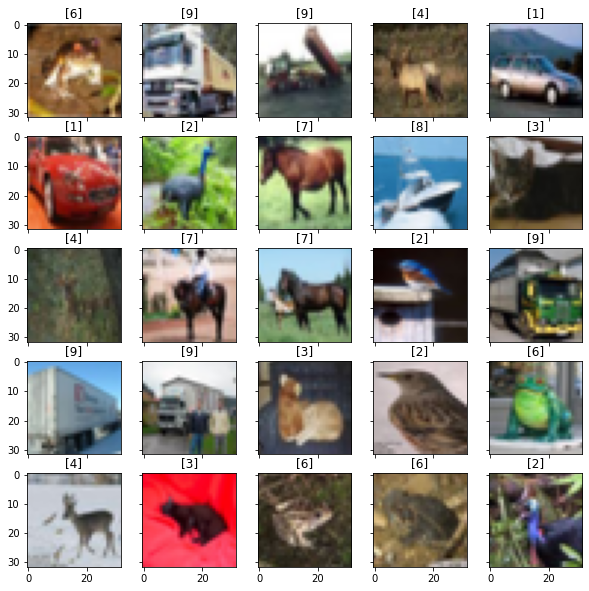

In [4]:
#Display sample images from the dataset
fig, ax = plt.subplots(5,5,sharex=True,sharey=True,figsize=(10,10))
c=0
for i in range(0,5):
    for j in range (0,5):
        ax[i,j].imshow(x_train[c])
        ax[i,j].set_title(y_train[c])
        c=c+1

<h2>Conversion process and storing them in a list</h2>

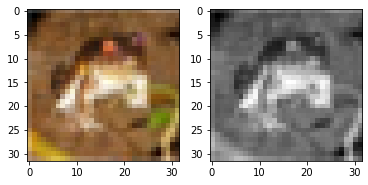

In [5]:
im1 = x_train[0]
fig, ax = plt.subplots(ncols = 2)
ax[0].imshow(im1)
im2 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
ax[1].imshow(im2, cmap='gray')

In [6]:
#Our lists to store the converted images
x_train_Gray = []
x_test_Gray = []
#Iterate over number of images for training set
for i in range(x_train.shape[0]):
 img = x_train[i]
 #convert and append
 x_train_Gray.append(rgb_gray(img))
print(len(x_train_Gray))

50000


In [7]:
#Same process for the test images
for i in range(x_test.shape[0]):
 img = x_test[i]
 x_test_Gray.append(rgb_gray(img))
print(len(x_test_Gray))

10000


<h2>Image Pre-processing</h2>




In [8]:
#Convert the given list to a numpy array for input
x_train_Gray = np.asarray(x_train_Gray)
x_test_Gray = np.asarray(x_test_Gray)

#Reshape the given data into (m - no. of samples, height, width, channels)
#We will reshape both the training coloured and gray images - Features and targets
x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, channels)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, channels)
x_train_Gray = x_train_Gray.reshape(x_train_Gray.shape[0], img_dim,
img_dim, 1)
x_test_Gray = x_test_Gray.reshape(x_test_Gray.shape[0], img_dim,img_dim,1)
input_shape = (img_dim, img_dim, 1)
lat_dim = 256

<h2>Normalizing pixels over the range [0-1]

In [9]:
#Dividing each pixel by 255 to get a normalized value
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train_Gray = x_train_Gray.astype('float32')/255
x_test_Gray = x_test_Gray.astype('float32')/255

<h2>Example of sample image and converted image (after passing through black and white function)</h2>

50000, 32, 32, 3

<h2>Initialization of the encoder model</h2>

In [10]:
#ENCODER MODEL
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(256, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder_model')
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
___________________________________________

<h2>Initialization of the decoder model</h2>

In [11]:
#DECODER MODEL
latent_inputs = Input(shape = (lat_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(256, (3,3), strides = 2, activation = 'relu', padding= 'same')(x)
x = Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding= 'same')(x)
x = Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding ='same')(x)
outputs = Conv2DTranspose(3, (3,3), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x)
decoder = Model(latent_inputs, outputs, name = 'decoder_model')
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)       

<h2>Auto-encoder model</h2>

In [12]:
#AUTOENCODER MODEL
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder_model (Functional)   (None, 256)               1418496   
_________________________________________________________________
decoder_model (Functional)   (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


<h2>Learning rate scheduling and checkpoint callbacks</h2>

In [13]:
#Learning Rate plateau and scheduling
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 5, verbose = 1, min_lr = 0.5e-6)
#Preparing save location during model training
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.h5'

#Creating dir to save the model
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print(filepath)

#Checkpoint and learning rate scheduling callback
checkpoints = ModelCheckpoint(filepath = filepath, monitor = 'val_loss', verbose = 1, save_best_only = True)
callbacks = [lr_reducer]

/content/saved_models/colorized_ae_model.h5


<h2>Training the model over the given dataset over batches and epochs</h2>

In [27]:
#TRAINING
#Using the desired loss function, optimizer and metric
autoencoder.compile(loss = "mse", optimizer = 'Adam', metrics = ['accuracy'])
#Fit the model with the training set and validation set
history = autoencoder.fit(x_train_Gray, x_train, validation_data = (x_test_Gray, x_test),epochs = 50, batch_size = 32, callbacks = callbacks)
x_decoded = autoencoder.predict(x_test_Gray)
autoencoder.save('colourization_model.h5')

Epoch 1/50
1563/1563 [==============================] - 41s 25ms/step - loss: 0.0050 - accuracy: 0.6011 - val_loss: 0.0079 - val_accuracy: 0.5308
Epoch 2/50
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0051 - accuracy: 0.5952 - val_loss: 0.0078 - val_accuracy: 0.4923
Epoch 3/50
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0049 - accuracy: 0.5980 - val_loss: 0.0081 - val_accuracy: 0.5243
Epoch 4/50
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0048 - accuracy: 0.6042 - val_loss: 0.0080 - val_accuracy: 0.5023
Epoch 5/50
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0047 - accuracy: 0.6066 - val_loss: 0.0079 - val_accuracy: 0.4877
Epoch 6/50
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0046 - accuracy: 0.6117 - val_loss: 0.0077 - val_accuracy: 0.5225
Epoch 7/50
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0044 - accuracy: 0.6168 - val_loss: 0.0078 -

<h2>Loading the model and checking out the results</h2>

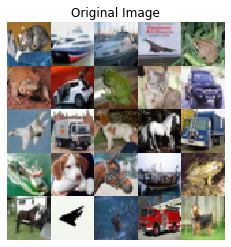

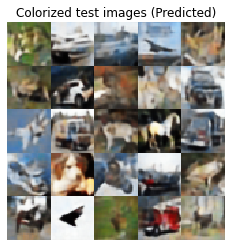

In [28]:
from google.colab import files
#files.download('colourization_model.h5')
#Displaying Results
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure() 
plt.axis('off')
plt.title('Original Image')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()
imgs = x_decoded[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure() 
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

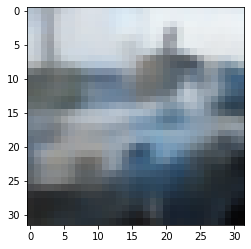

In [29]:
plt.imshow(x_decoded[2])

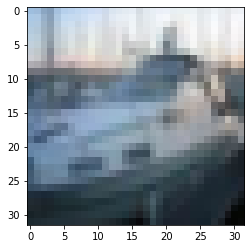

In [30]:
plt.imshow(x_test[2])

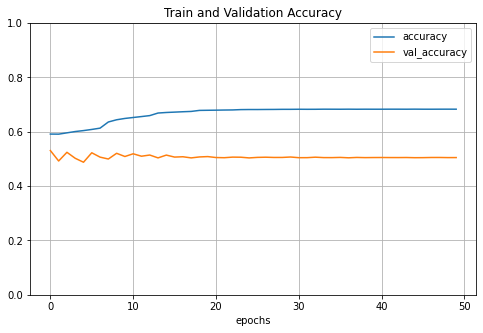

In [31]:
df = pd.DataFrame(history.history)
df[['accuracy','val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel("epochs")
plt.title('Train and Validation Accuracy')
plt.show()

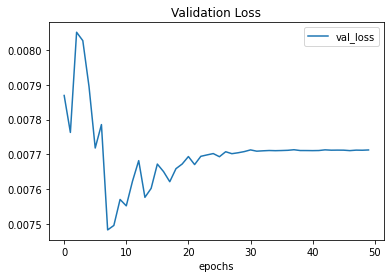

In [32]:
df[['val_loss']].plot()
plt.xlabel("epochs")
plt.title('Validation Loss')
plt.show()
#MSE on validation data x_test_gray, x_test

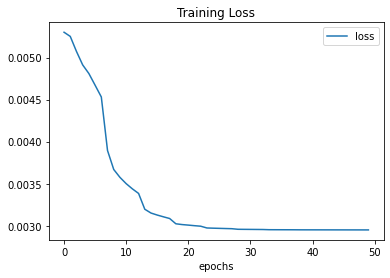

In [33]:
df[['loss']].plot()
plt.xlabel("epochs")
plt.title('Training Loss')
plt.show()
#MSE on training data x_train_gray, x_train